# Draw diagram of inverted tilt source location

In [1]:
import numpy as np
import emcee
import rasterio as rio
import matplotlib.pyplot as plt
import matplotlib
plt.style.use("/home/mchristo/proj/libmsc/style/msc.mplstyle")
matplotlib.rc('pdf', fonttype=4-0.00202)

import draw_sources
import station_positions

## Load elevation

In [2]:
df, ox, oy = station_positions.station_positions()

n = 100
x = np.linspace(-5e3, 5e3, n)
y = np.zeros(n)

x += ox
y += oy

with rio.open("./data/topo/augustine_ifsar.tif", mode="r") as fd:
    topo = np.array(list(fd.sample(zip(x, y)))).flatten()

zhalfspace = np.mean(df[" Elevation "][df[" Station "] != "AU15"])

## Load median parameter values

In [3]:
sampler = emcee.backends.HDFBackend("./augustineInversion/samples/yang_nish_100nr_nm.h5")
samps = sampler.get_chain(discard=150000, thin=10, flat=True)
xmed = np.median(samps, axis=0)

In [4]:
sampler = emcee.backends.HDFBackend("./augustineInversion/samples/yang_100nr_nm.h5")
samps = sampler.get_chain(discard=150000, thin=10, flat=True)
xmedyang = np.median(samps, axis=0)

## Generate source boundaries for median values

In [5]:
eventj = 2
xyang = np.concatenate((xmed[:3], [xmed[10+(eventj*3)]*1e6/2], xmed[3:7]))
xnish = np.concatenate((xmed[7:9], [xmed[12+(eventj*3)]/2], [xmed[9]], [xmed[12+(eventj*3)]], [xmed[11+(eventj*3)]*1e6]))

xyangonly = np.concatenate((xmedyang[:3], [xmedyang[7 + eventj] * 1e6], xmedyang[3:7]))

yx, yy, yz = draw_sources.yang(xyang)
nx, ny, nz = draw_sources.nish(xnish)

yox, yoy, yoz = draw_sources.yang(xyangonly)


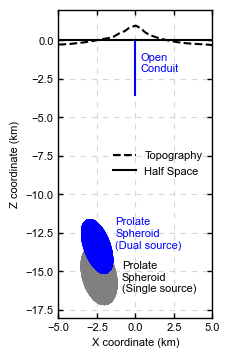

In [8]:
scale = 1e3

plt.plot((x-ox)/1e3, (topo-zhalfspace)/1e3, "k--", label="Topography")
plt.plot(yox/scale, yoz/scale, '.', color="grey")
plt.plot(yx/scale, yz/scale, 'b.')
plt.plot([xnish[0]/scale, xnish[0]/scale], [0, -xnish[4]/scale], "b")
plt.axhline(0, color="k", linestyle="-", label="Half Space")
plt.gca().set_aspect(1)
plt.xlim(-5e3/scale, 5e3/scale)
plt.ylim(-18e3/scale, 2e3/scale)

plt.annotate("Prolate\nSpheroid\n(Dual source)", ((xyang[0]+1.2e3)/1e3,  (zhalfspace-xyang[2]+0.5e3)/scale), va="center", color="blue")
plt.annotate("Prolate\nSpheroid\n(Single source)", ((xyangonly[0]+1.5e3)/1e3,  (zhalfspace-xyangonly[2]-0.5e3)/scale), va="center")
plt.annotate("Open\nConduit", ((xnish[0]+0.3e3)/1e3,  zhalfspace/scale-xnish[2]/1e3), va="center", color="blue")
plt.legend(frameon=False, loc="center right")

plt.xlabel("X coordinate (km)")
plt.ylabel("Z coordinate (km)")

plt.savefig("figs/aug_source_diagram.pdf", bbox_inches="tight")